In [1]:
import numpy as np
np.random.seed(123)

%load_ext autoreload
%autoreload 2

In [2]:
def fienup_phase_retrieval(mag, mask=None, beta=0.8, 
                           steps=200, mode='hybrid', verbose=True):
    """
    Implementation of Fienup's phase-retrieval methods. This function
    implements the input-output, the output-output and the hybrid method.
    
    Note: Mode 'output-output' and beta=1 results in 
    the Gerchberg-Saxton algorithm.
    
    Parameters:
        mag: Measured magnitudes of Fourier transform
        mask: Binary array indicating where the image should be
              if padding is known
        beta: Positive step size
        steps: Number of iterations
        mode: Which algorithm to use
              (can be 'input-output', 'output-output' or 'hybrid')
        verbose: If True, progress is shown
    
    Returns:
        x: Reconstructed image
    
    Author: Tobias Uelwer
    Date: 30.12.2018
    
    References:
    [1] E. Osherovich, Numerical methods for phase retrieval, 2012,
        https://arxiv.org/abs/1203.4756
    [2] J. R. Fienup, Phase retrieval algorithms: a comparison, 1982,
        https://www.osapublishing.org/ao/abstract.cfm?uri=ao-21-15-2758
    [3] https://github.com/cwg45/Image-Reconstruction
    """
    
    assert beta > 0, 'step size must be a positive number'
    assert steps > 0, 'steps must be a positive number'
    assert mode == 'input-output' or mode == 'output-output'\
        or mode == 'hybrid',\
    'mode must be \'input-output\', \'output-output\' or \'hybrid\''
    
    if mask is None:
        mask = np.ones(mag.shape)
        
    assert mag.shape == mask.shape, 'mask and mag must have same shape'
    
    # sample random phase and initialize image x 
    y_hat = mag*np.exp(1j*2*np.pi*np.random.rand(*mag.shape))
    x = np.zeros(mag.shape)
    
    # previous iterate
    x_p = None
        
    # main loop
    for i in range(1, steps+1):
        # show progress
        if i % 100 == 0 and verbose: 
            print("step", i, "of", steps)
        
        # inverse fourier transform
        y = np.real(np.fft.ifft2(y_hat))
        
        # previous iterate
        if x_p is None:
            x_p = y
        else:
            x_p = x 
        
        # updates for elements that satisfy object domain constraints
        if mode == "output-output" or mode == "hybrid":
            x = y
            
        # find elements that violate object domain constraints 
        # or are not masked
        indices = np.logical_or(np.logical_and(y<0, mask), 
                                np.logical_not(mask))
        
        # updates for elements that violate object domain constraints
        if mode == "hybrid" or mode == "input-output":
            x[indices] = x_p[indices]-beta*y[indices] 
        elif mode == "output-output":
            x[indices] = y[indices]-beta*y[indices] 
        
        # fourier transform
        x_hat = np.fft.fft2(x)
        
        # satisfy fourier domain constraints
        # (replace magnitude with input magnitude)
        y_hat = mag*np.exp(1j*np.angle(x_hat))
    return x

In [3]:
import sys
sys.path.append('..')

In [4]:
from data import load

In [ ]:
test_data = load(name='MNIST', path='../data/mnist/', batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()
results = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 100==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(3):
        res.append(fienup_phase_retrieval(magnitudes, steps=1000, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1])) - magnitudes)**2))     
    results[i] = res[np.argmin(errors)]

In [6]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/HIO_MNIST/original_1.p", "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/HIO_MNIST/predicted_1.p", "wb"))

In [7]:
### LOAD RESULTS ###
import pickle

batch = pickle.load(open("/home/shared/phase-retrieval/test/HIO_MNIST/original_1.p", "rb"))
results = pickle.load(open("/home/shared/phase-retrieval/test/HIO_MNIST/predicted_1.p", "rb"))

In [8]:
from util import plot_grid

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/MNIST_HIO.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 800x800 with 1 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


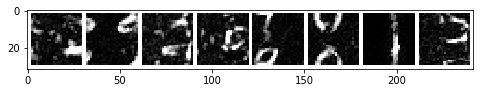

In [9]:
plot_grid(results[8:16, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/MNIST_HIO_small.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


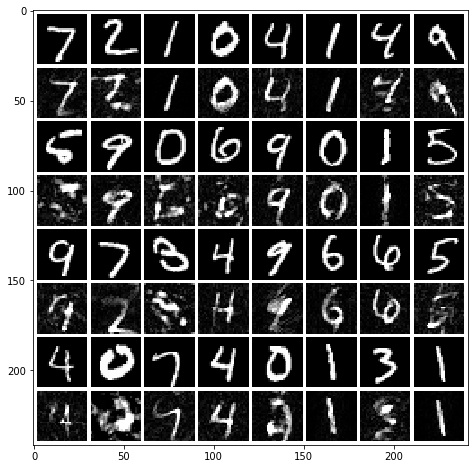

In [10]:
from util import register_croco

results_reg = register_croco(results, batch)

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/MNIST_HIO_reg.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


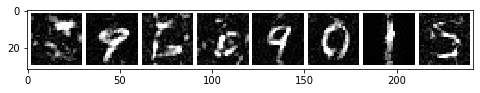

In [11]:
plot_grid(results_reg[8:16, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/MNIST_HIO_small_reg.png")

In [12]:
from util import benchmark
benchmark(results, batch, check_all=True)

Signal error:
  MSE: 0.17054242039012024, std: 0.062448591184072456
  MAE: 0.2248699701485748, std: 0.06890454139896075
  SSIM: 0.08849763454128837, std: 0.13323991218789485
  Sharpness: 0.14263364315467142, std: 0.07242534081624206
  PhCo-MSE: 0.05445528243589809, std: 0.04456950599156786
  PhCo-MAE: 0.11142985784439383, std: 0.06566919432715336
  PhCo-SSIM: 0.5291751728271519, std: 0.2517375627682573
  CroCo-MSE: 0.04411033219625654, std: 0.03382546999084973
  CroCo-MAE: 0.10157947497676809, std: 0.05723777425185423
  CroCo-SSIM: 0.5708032250314031, std: 0.22186004947577645

Magnitude error:
  MSE Magnitude: 1.3815937563893441, std: 1.1584847108506904

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 3.22] - should be in [0, 1]

Markdown table values:
 0.1705 | 0.2249 | 0.08850 | 0.1426 | 0.05446 | 0.1114 | 0.5292 | 0.04411 | 0.1016 | 0.5708 | 1.382 |


## HIO MNIST

| steps | restarts | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 200 | 5 | 0.1705 | 0.2257 | 0.08605 | | 0.05469 | 0.1123 | 0.5293 | 0.04323 | 0.1014 | 0.5738 | 1.422 |
| 1000 | 3 | 0.1705 | 0.2249 | 0.08850 | 0.1426 | 0.05446 | 0.1114 | 0.5292 | 0.04411 | 0.1016 | 0.5708 | 1.382 |


In [13]:
test_data = load(name='Fashion', path='../data/fashion/', batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()
results_fashion = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 100==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(3):
        res.append(fienup_phase_retrieval(magnitudes, steps=1000, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))     
    results_fashion[i] = res[np.argmin(errors)]

Fashion
0
100
200
300
400
500
600
700
800
900
1000


In [14]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/HIO_Fashion/original_1.p", "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/HIO_Fashion/predicted_1.p", "wb"))

In [15]:
### LOAD RESULTS ###
import pickle

batch = pickle.load(open("/home/shared/phase-retrieval/test/HIO_Fashion/original_1.p", "rb"))
results = pickle.load(open("/home/shared/phase-retrieval/test/HIO_Fashion/predicted_1.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


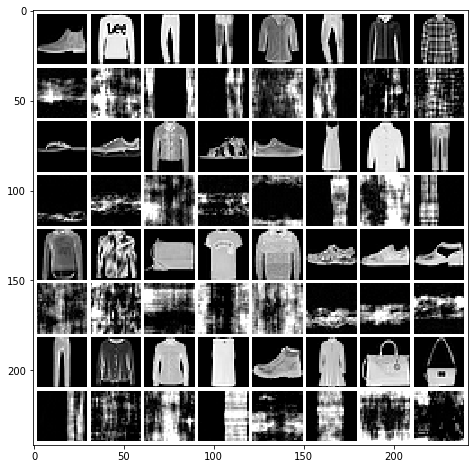

In [16]:
to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_fashion[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)

plot_grid(to_plot, figsize=(8,8), file="../out/hio/Fashion_HIO.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


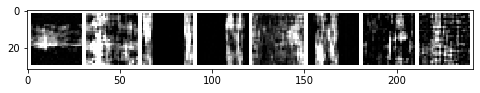

In [17]:
plot_grid(results_fashion[0:8, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/Fashion_HIO_small.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


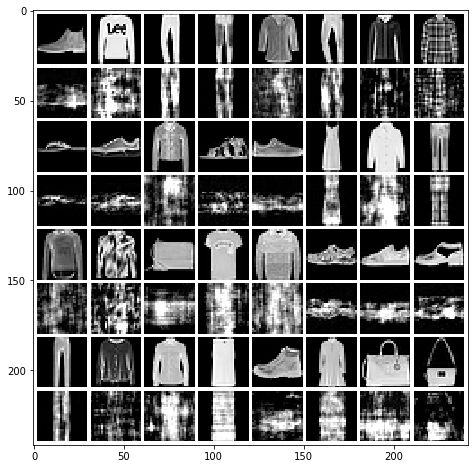

In [18]:
results_reg = register_croco(results_fashion, batch)

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/Fashion_HIO_reg.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


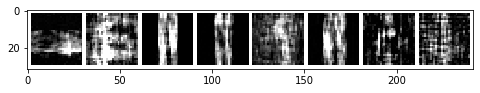

In [19]:
plot_grid(results_reg[0:8, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/Fashion_HIO_small_reg.png")

In [20]:
benchmark(results_fashion, batch, check_all=True)

Signal error:
  MSE: 0.22027591932510404, std: 0.12919307351983783
  MAE: 0.3386957163493207, std: 0.13861857435417527
  SSIM: 0.05945344992917688, std: 0.13213182965946982
  Sharpness: 0.18732188692016263, std: 0.0701015958901477
  PhCo-MSE: 0.12283506787216061, std: 0.11007574016206055
  PhCo-MAE: 0.22634233085527633, std: 0.1371872677871968
  PhCo-SSIM: 0.31509134760333124, std: 0.24557695305884572
  CroCo-MSE: 0.06461288415366176, std: 0.04349648795376737
  CroCo-MAE: 0.16036146269589047, std: 0.07620028275740892
  CroCo-SSIM: 0.4403594574421796, std: 0.19950994886617734

Magnitude error:
  MSE Magnitude: 0.02562481446720952, std: 0.07999100992761399

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 2.83] - should be in [0, 1]

Markdown table values:
 0.2203 | 0.3387 | 0.05945 | 0.1873 | 0.1228 | 0.2263 | 0.3151 | 0.06461 | 0.1604 | 0.4404 | 0.02562 |


## HIO Fashion

| steps | restarts | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 200 | 5 | 0.2266 | 0.3453 | 0.05072 | | 0.1197 | 0.2245 | 0.3084 | 0.06460 | 0.1614 | 0.4319 | 0.04905 |
| 1000 | 3 | 0.2203 | 0.3387 | 0.05945 | 0.1873 | 0.1228 | 0.2263 | 0.3151 | 0.06461 | 0.1604 | 0.4404 | 0.02562 |
